# Employee Attrition Prediction
## Task 1: HR Analytics - IBM HR Dataset
**Objective**: Predict employee attrition and derive retention strategies

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_auc_score, RocCurveDisplay)
import shap
import warnings
warnings.filterwarnings('ignore')

## 2. Load and Explore Dataset

In [2]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## 3. Exploratory Data Analysis (EDA)

### Basic Information

In [3]:
print("\nMissing Values:")
print(df.isnull().sum())  # Check for missing values

print("\nData Types:")
print(df.dtypes.value_counts())


Missing Values:
Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole     

### Target Variable Analysis

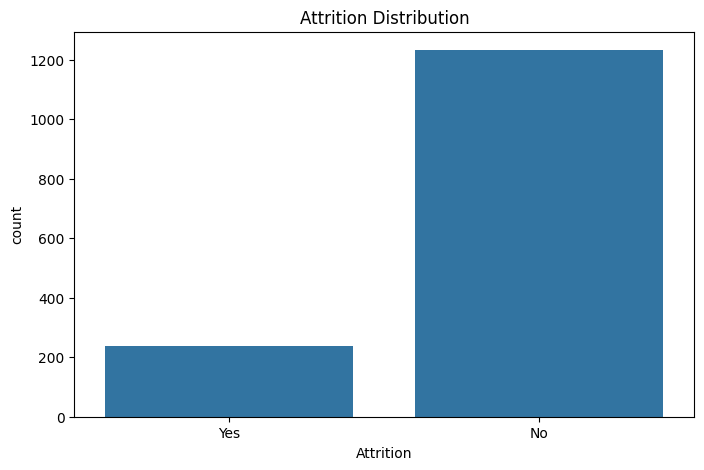

In [5]:
plt.figure(figsize=(8,5))
sns.countplot(x='Attrition', data=df)
plt.title('Attrition Distribution')
plt.show()

### Numerical Features Analysis

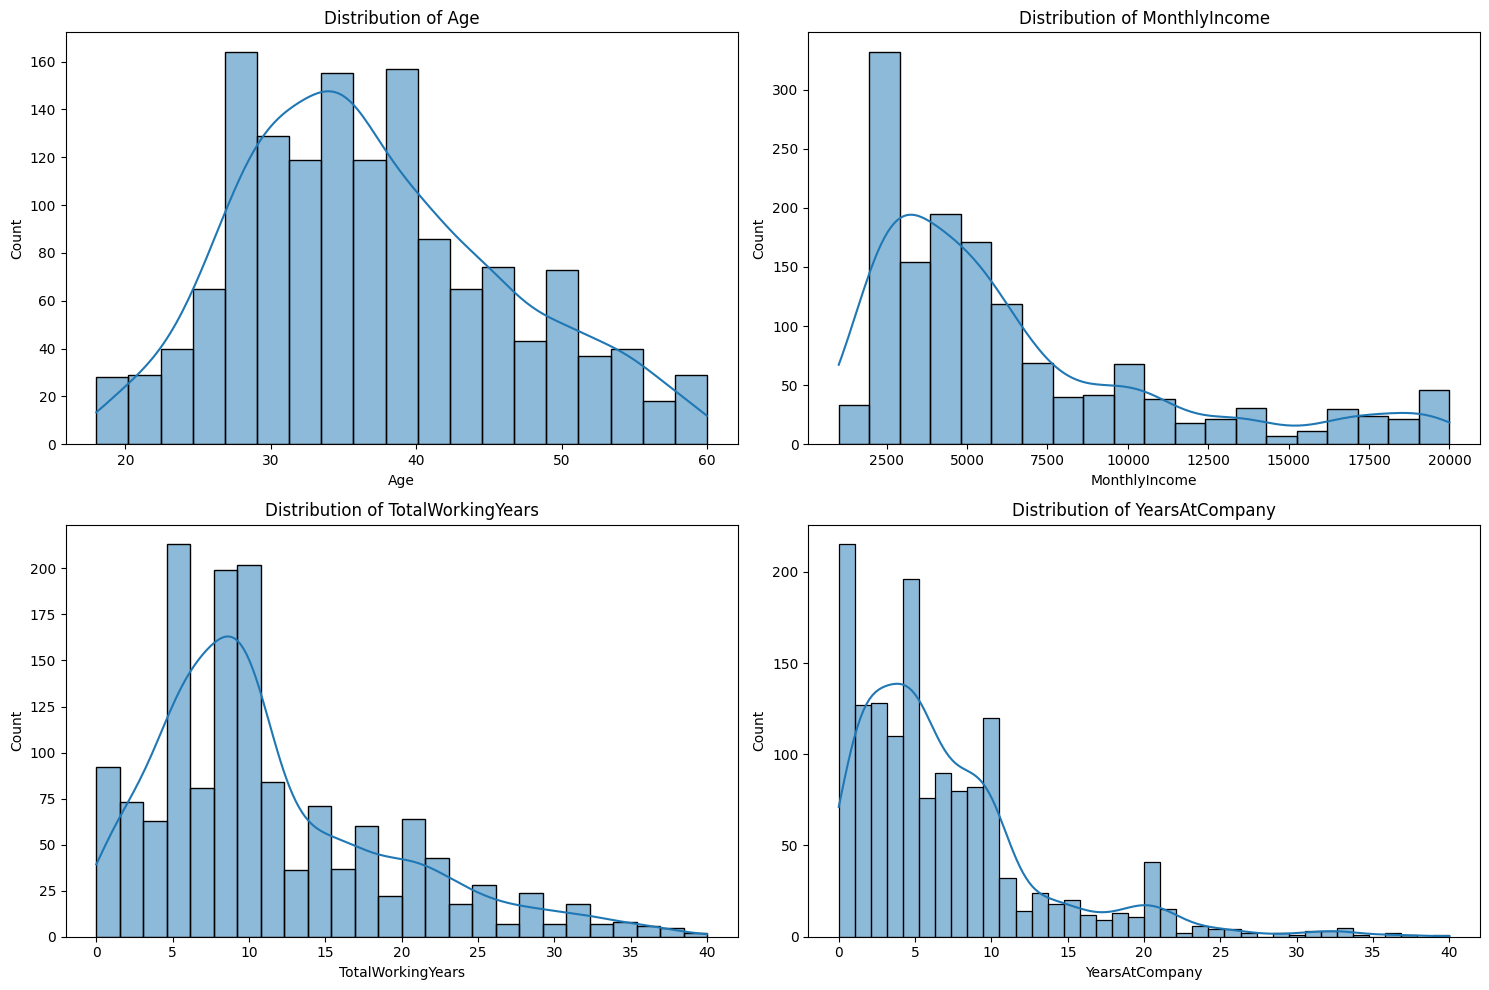

In [6]:
num_features = ['Age', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany']
plt.figure(figsize=(15,10))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2,2,i)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

### Categorical Features Analysis

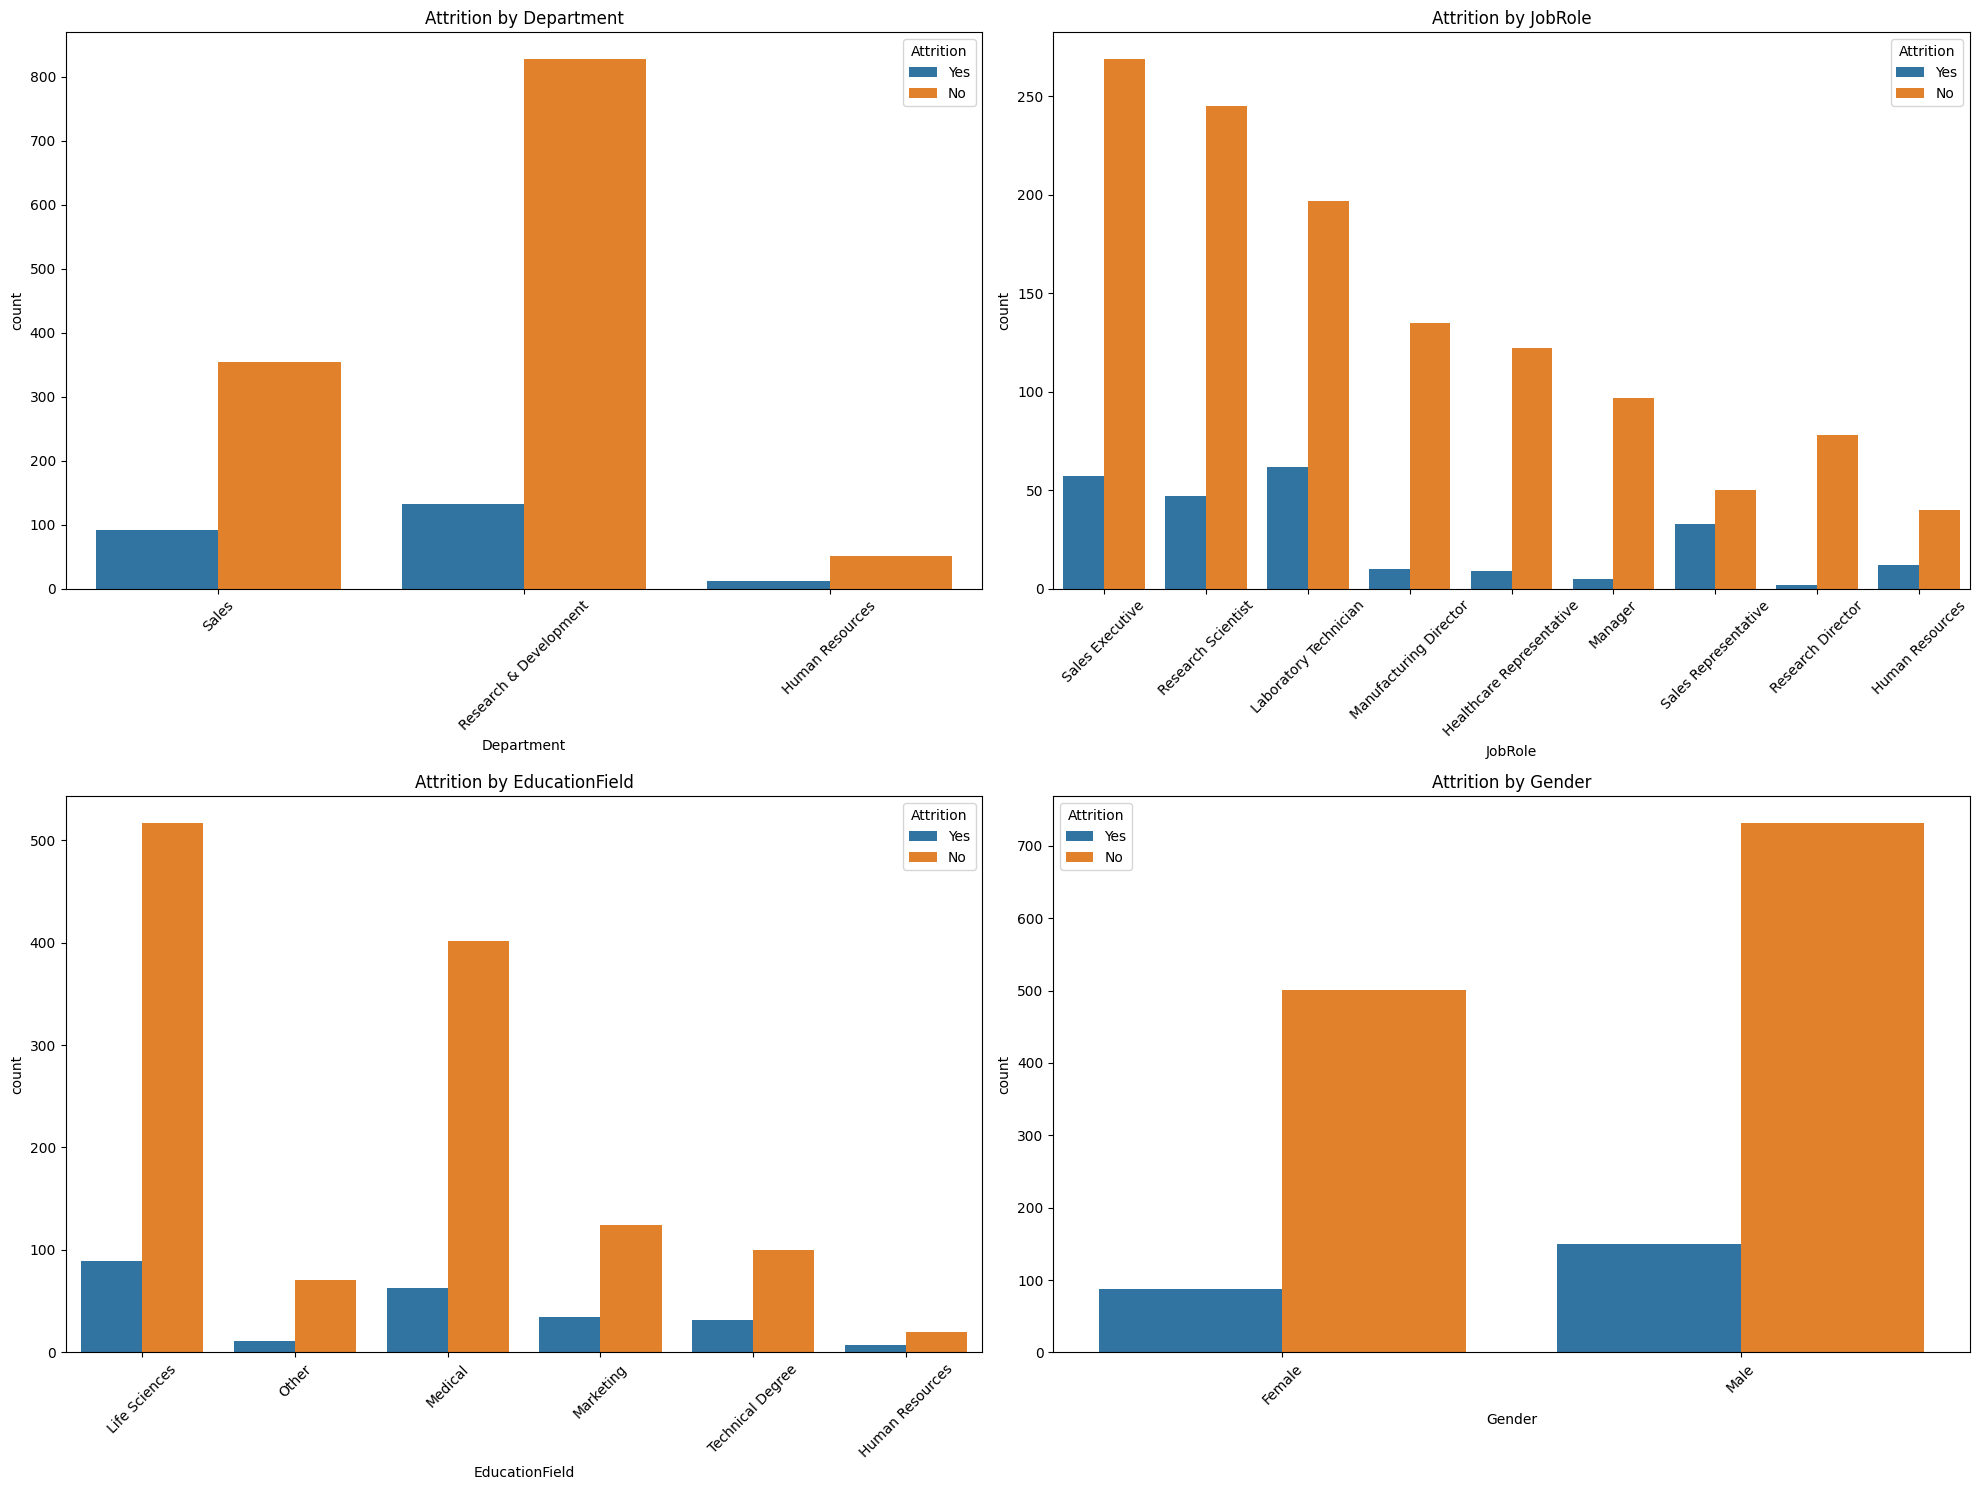

In [7]:
cat_features = ['Department', 'JobRole', 'EducationField', 'Gender']
plt.figure(figsize=(20,15))
for i, feature in enumerate(cat_features, 1):
    plt.subplot(2,2,i)
    sns.countplot(x=feature, hue='Attrition', data=df)
    plt.title(f'Attrition by {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Correlation Analysis

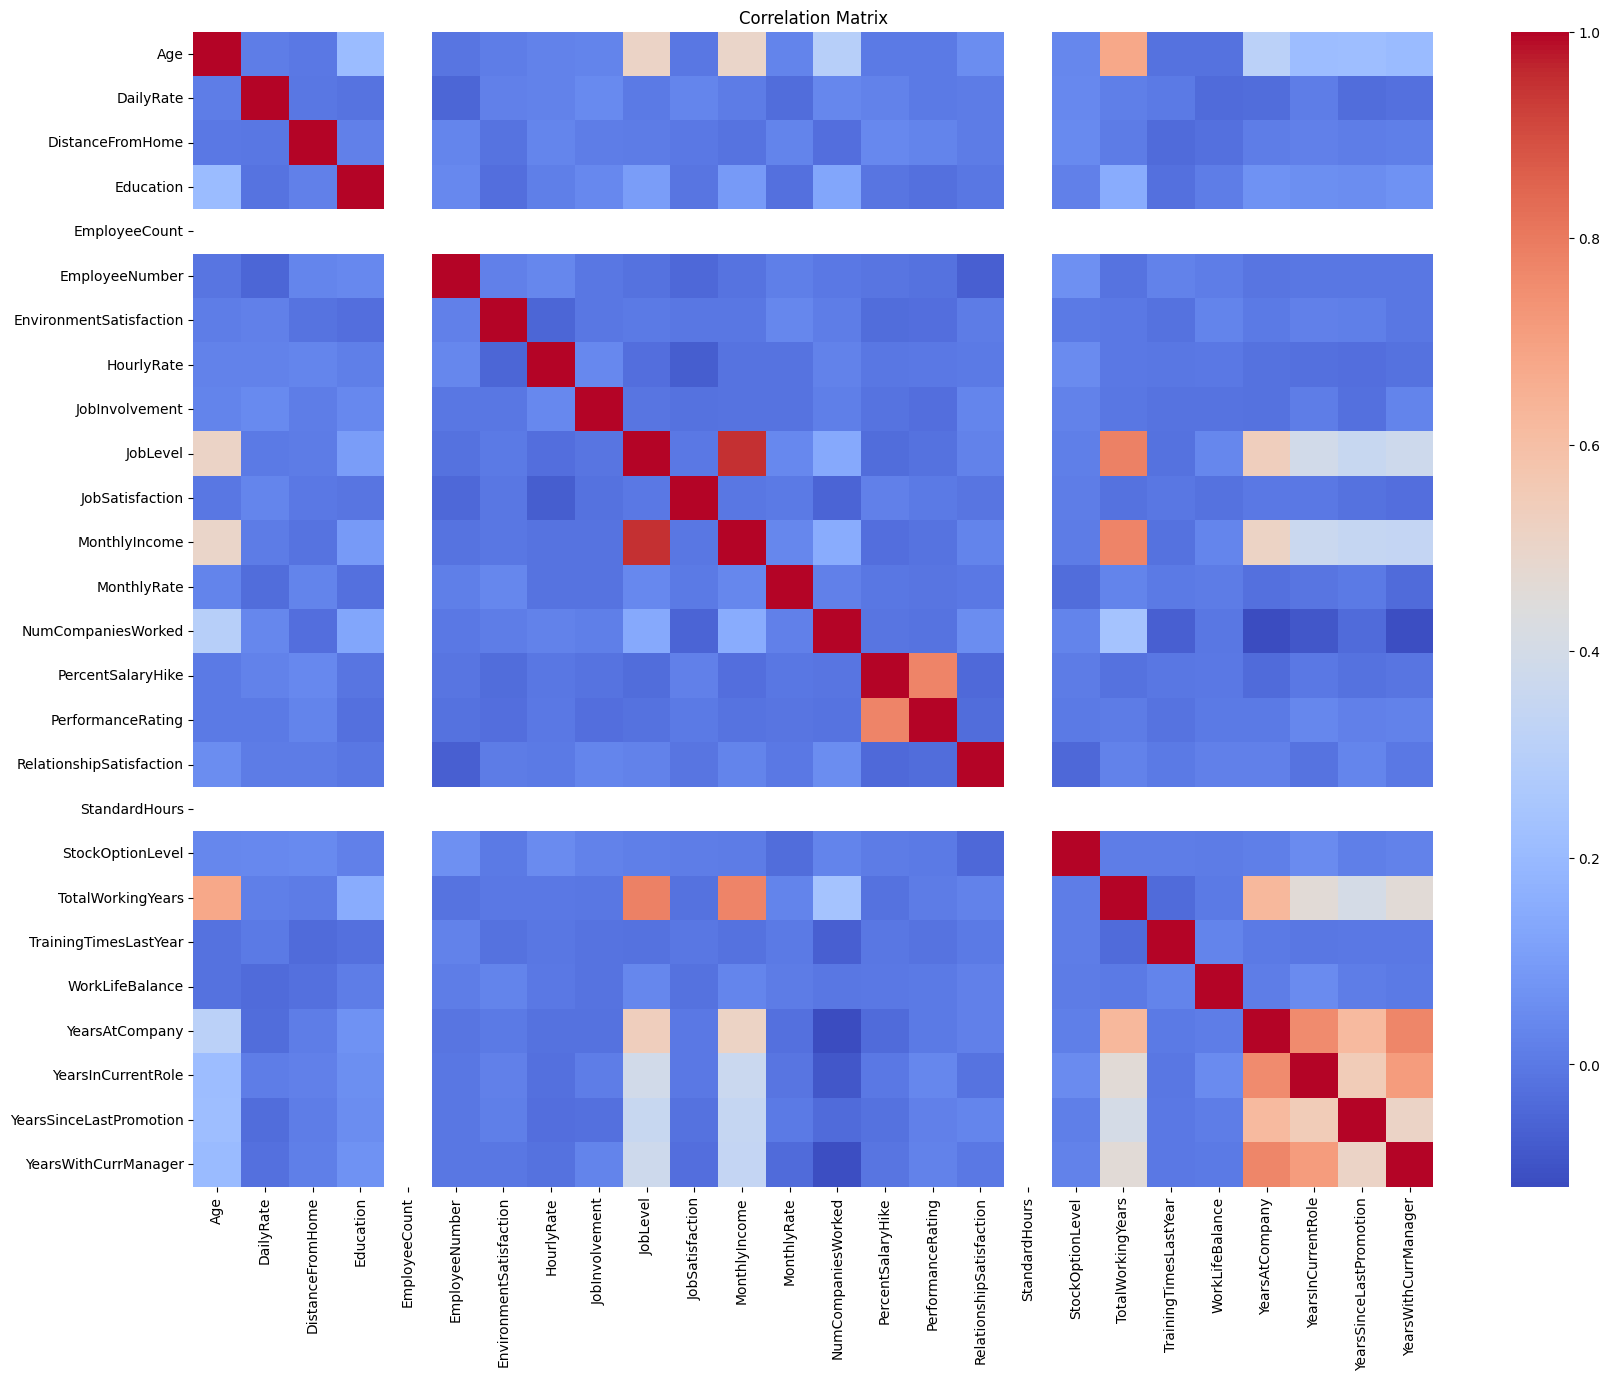

In [8]:
plt.figure(figsize=(20,15))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## 4. Data Preprocessing

### Encode Target Variable

In [9]:
df['Attrition'] = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

### Handle Categorical Variables

In [10]:
# Separate numerical and categorical features
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

In [11]:
# One-hot encoding for categorical variables
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

### Train-Test Split

In [12]:
X = df_encoded.drop('Attrition', axis=1)
y = df_encoded['Attrition']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

### Feature Scaling

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5. Model Building

### Logistic Regression

In [14]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

In [15]:
print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:,1]))

Logistic Regression Performance:
Accuracy: 0.74
              precision    recall  f1-score   support

           0       0.91      0.77      0.83       247
           1       0.33      0.62      0.43        47

    accuracy                           0.74       294
   macro avg       0.62      0.69      0.63       294
weighted avg       0.82      0.74      0.77       294

ROC AUC: 0.7954173486088381


### Random Forest

In [16]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

In [17]:
print("\nRandom Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:,1]))


Random Forest Performance:
Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       247
           1       0.50      0.09      0.15        47

    accuracy                           0.84       294
   macro avg       0.67      0.53      0.53       294
weighted avg       0.79      0.84      0.79       294

ROC AUC: 0.7671634077009217


## 6. Model Interpretation with SHAP

### SHAP Summary Plot

Shape of shap_values: (294, 47, 2)


<Figure size 1000x800 with 0 Axes>

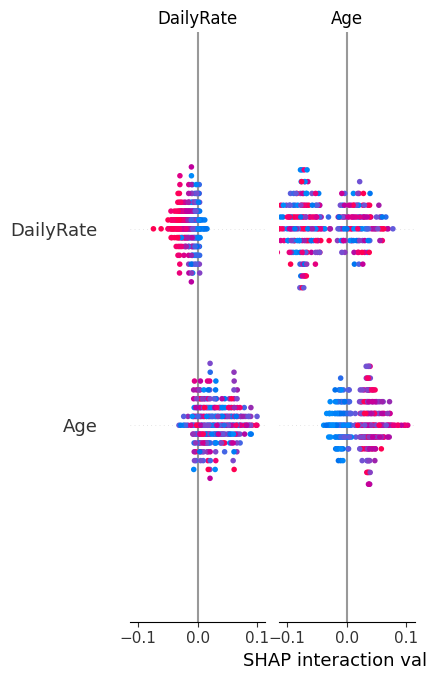

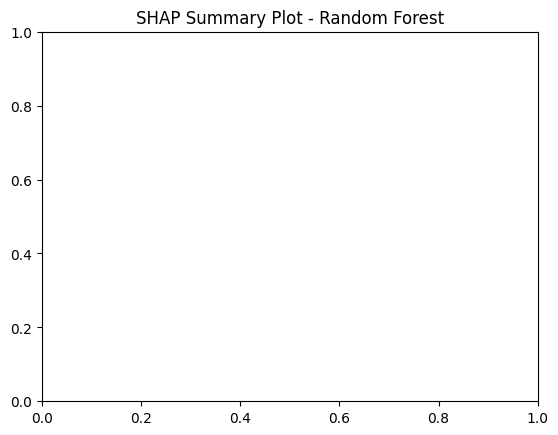

In [22]:
# Corrected SHAP Code
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_scaled)

# Check the shape of shap_values
print("Shape of shap_values:", np.array(shap_values).shape)

# For binary classification, shap_values returns a list of two arrays (one for each class)
# We use the second array (index 1) for the positive class (Attrition = 1)
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Use the values for the positive class

# Plot SHAP summary plot
plt.figure(figsize=(10,8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)
plt.title('SHAP Summary Plot - Random Forest')
plt.show()

In [24]:
print("Shape of X_test_scaled:", X_test_scaled.shape)

Shape of X_test_scaled: (294, 47)


### Feature Importance

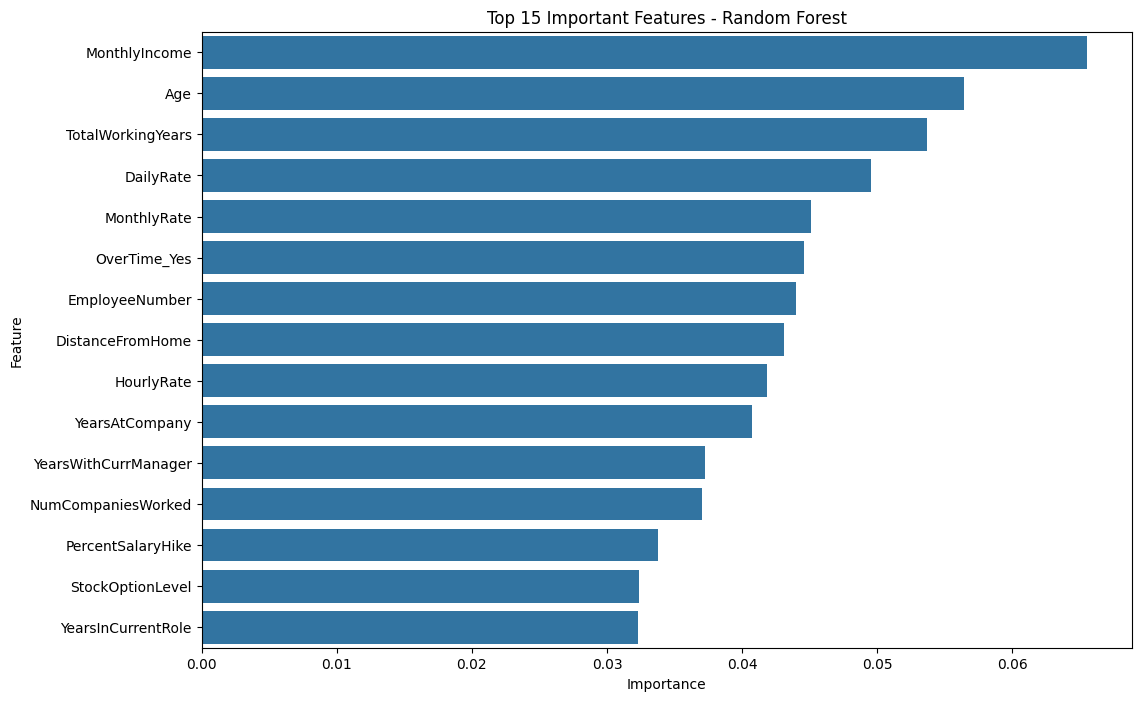

In [26]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Important Features - Random Forest')
plt.show()

## 7. Actionable Insights

### Key Findings

In [27]:
print("Top Factors Influencing Attrition:")
print(feature_importance.head(10).to_string(index=False))

Top Factors Influencing Attrition:
          Feature  Importance
    MonthlyIncome    0.065545
              Age    0.056391
TotalWorkingYears    0.053667
        DailyRate    0.049556
      MonthlyRate    0.045082
     OverTime_Yes    0.044595
   EmployeeNumber    0.043967
 DistanceFromHome    0.043111
       HourlyRate    0.041827
   YearsAtCompany    0.040748


### Retention Strategies

In [28]:
print("""
**Recommended Retention Strategies:**
1. Focus on improving Job Satisfaction through regular employee feedback
2. Implement Work-Life Balance initiatives (flexible hours, remote work options)
3. Review compensation packages for employees in high-risk categories
4. Create career development plans for employees with long tenure
5. Address environmental satisfaction through workplace improvements
6. Monitor overtime hours and workload distribution
7. Implement recognition programs for employees with many years at company
""")


**Recommended Retention Strategies:**
1. Focus on improving Job Satisfaction through regular employee feedback
2. Implement Work-Life Balance initiatives (flexible hours, remote work options)
3. Review compensation packages for employees in high-risk categories
4. Create career development plans for employees with long tenure
5. Address environmental satisfaction through workplace improvements
6. Monitor overtime hours and workload distribution
7. Implement recognition programs for employees with many years at company

